# Pre-processing and Training Data
In this notebook the data set is further preprocessed to meet the criteria for the modeling step. This includes further analysis of the relevant features and creating a training data set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from IPython.display import display
import scipy as sp
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix, save_npz, load_npz

## Load the Data

In [2]:
df = pd.read_sql('SELECT * FROM data_base_error ', 'sqlite:///../data/data2.db',index_col='index')
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38432 entries, 0 to 38431
Data columns (total 36 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id_000   38432 non-null  int64 
 1   ty_000   38432 non-null  object
 2   cl_000   38432 non-null  object
 3   xx_000   38432 non-null  object
 4   id_001   38432 non-null  object
 5   xx_001   38432 non-null  object
 6   cl_001   38432 non-null  object
 7   id_002   38432 non-null  object
 8   id_003   38432 non-null  object
 9   id_004   38432 non-null  object
 10  id_005   38432 non-null  object
 11  id_006   38432 non-null  object
 12  id_007   38432 non-null  object
 13  id_008   38432 non-null  object
 14  xx_005   38432 non-null  int64 
 15  ty_002   38432 non-null  object
 16  ty_004   38432 non-null  object
 17  cl_003   38432 non-null  object
 18  id_018   38432 non-null  object
 19  id_019   38432 non-null  object
 20  xx_014   38432 non-null  object
 21  cl_006   38432 non-null  object
 22

In [3]:
df.drop(['id_000','id_033','xx_026'],axis=1,inplace=True)

### Make proper datetime feature

In [4]:
x = 'dt_001'
df[x] = pd.to_datetime(df[x])
df.loc[:,x] = df[x].apply(lambda y: y.replace(microsecond=0))

### xx_005 is an ordinal variable

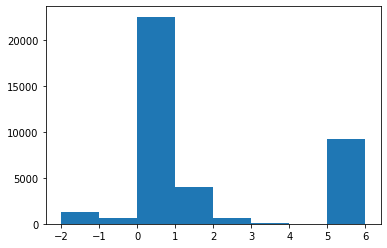

In [5]:
plt.hist(df['xx_005'],bins=range(-2,7))
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(df['xx_005'].values.reshape(-1,1))
df['xx_005'] = mms.transform(df['xx_005'].values.reshape(-1,1))

## Create dummy features

In [6]:
df_dum = df.copy()
for var in df_dum.columns:
    if (var == 'id_000')|(var == 'id_033')|(var == 'dt_001'):
        continue
    if (df_dum[var].dtype=='O'):
        if ('1' in df_dum[var].unique())|('0.0' in df_dum[var].unique())|(('0' in df_dum[var].unique())):
            print(var, ' has integers as strings')
            continue
            
        if isinstance(df[var].unique()[0],str):
            if sum([1 if var not in value else 0 for value in df[var].unique()]) > 0:
                df_temp = pd.get_dummies(df[var],drop_first=True,prefix_sep='_',prefix=var)
            else:
                df_temp = pd.get_dummies(df[var],drop_first=True)
        else:
            df_temp = pd.get_dummies(df[var],drop_first=True)
        df_dum = pd.concat([df_dum.drop(var,axis=1),df_temp],axis=1)
        del df_temp
    else:
        print('Integer values: ',var,' ::: ',df_dum[var].nunique())


Integer values:  xx_005  :::  8
Integer values:  xx_016  :::  991
Integer values:  xx_028  :::  63
Integer values:  error  :::  2


In [7]:
print('Before: ',df.shape,' after:',df_dum.shape)

Before:  (38432, 33)  after: (38432, 7721)


## First Data Set: No Feature Engineering

#### xx_016 and xx_028 are numerical

In [8]:
df_base = df_dum.copy()
for var in ['xx_016','xx_028']:
    mms = MinMaxScaler()
    mms.fit(df_base[var].values.reshape(-1,1))
    df_base[var] = mms.transform(df[var].values.reshape(-1,1))

In [9]:
df_base.drop('dt_001',axis=1,inplace=True)

## Split test and training data set

In [10]:
print('Errors make up only {:.2f}% of the data set.'.format(df_base['error'].sum()/df_base['error'].count()*100))

Errors make up only 4.91% of the data set.


Therefore, the test and training set are split such that each has 4.83 % errors.

In [11]:
import scipy as sp
from sklearn.model_selection import train_test_split
y = df_base['error'].values
X = sp.sparse.csr_matrix(df_base.drop('error',axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify=y)
print('Training data: ',len(y_train),' Testing data: ',len(y_test))

Training data:  30745  Testing data:  7687


In [12]:
print('In the train set errors make up {:.2f}% of the data.'.format(y_train.sum()/len(y_train)*100))
print('In the test set errors make up {:.2f}% of the data.'.format(y_test.sum()/len(y_test)*100))

In the train set errors make up 4.91% of the data.
In the test set errors make up 4.90% of the data.


## Save data sets

In [13]:
con = sqlite3.connect('../data/model_base.db')
pd.DataFrame(y_train,columns=['error']).to_sql(name='y_train', con=con, if_exists='replace')
pd.DataFrame(y_test,columns=['error']).to_sql(name='y_test', con=con, if_exists='replace')
con.close()

In [14]:
from scipy.sparse import csr_matrix, save_npz, load_npz

save_npz('../data/base_Xtrain.npz',X_train)
save_npz('../data/base_Xtest.npz',X_test)
np.save('../data/base_columns',df_dum.columns)

## Data set with Clusters and Datetime Features
### Create clusters for xx_016 and xx_28
We have inside knowledge that these features contain numerical data and to compare it to the other features, clusters are defined.

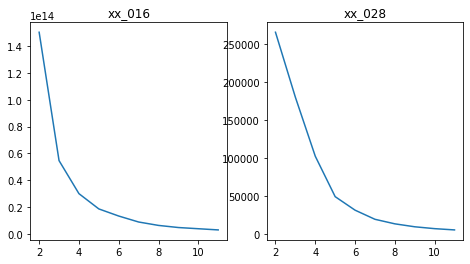

In [15]:
from sklearn.cluster import KMeans
plt.figure(figsize=(12,4))
k = 1
for var in ['xx_016','xx_028']:
    inertia = []

    for nc in range(2,12):
        kmeans = KMeans(n_clusters=nc)
        kmeans.fit(df[var].values.reshape(-1,1))
        inertia.append(kmeans.inertia_)  
    plt.subplot(1,3,k)
    plt.plot(range(2,12),inertia)
    plt.title(var)
    k+=1


In [16]:
from sklearn.preprocessing import MinMaxScaler
df_combo = df.copy()
for var in ['xx_016','xx_028']:
    if var == 'xx_028':
        n_clust = 5
    else:
        n_clust = 4
    # Generate new cluster
    kmeans = KMeans(n_clusters=n_clust)
    df_temp = pd.DataFrame(df_combo[var].copy())
    df_temp[var+'_cluster'] = kmeans.fit_predict(df_combo[var].values.reshape(-1,1))
    # analyze cluster
    tab = df_temp.groupby(var+'_cluster').agg({var:['mean','min','max','std']})
    #print(tab)
    # sort cluster
    new_clust = np.argsort(tab[var].loc[:,'min'])
    temp = np.zeros(len(df_temp[var+'_cluster']),dtype=int)
    for i in range(len(new_clust)):
        #print(i,new_clust[i])
        temp[df_temp[var+'_cluster']==new_clust[i]]=i
    df_temp.loc[:,var+'_cluster'] = temp
    print(df_temp.groupby(var+'_cluster').agg({var:['mean','min','max','std']}))
    # Create dummy features
    df_temp2 = pd.get_dummies(df_temp[var+'_cluster'],prefix=var, prefix_sep='_')
    # Add to data set
    df_combo = pd.concat([df_combo,df_temp2],axis=1)
    # Rescale the data set
    mms = MinMaxScaler()
    mms.fit(df_combo[var].values.reshape(-1,1))
    df_combo[var] = mms.transform(df_combo[var].values.reshape(-1,1))

                       xx_016                              
                         mean     min     max           std
xx_016_cluster                                             
0                  954.811861       0  170000  11335.080341
1               346677.467105  179700  437600  61848.089901
2               538566.912610  447000  618200  46043.352644
3               704526.062992  621800  921528  59939.416659
                    xx_028                    
                      mean min  max        std
xx_028_cluster                                
0                 0.006152   0    1   0.078197
1                 2.551692   2    6   0.809375
2                10.495624   7   24   3.522496
3                38.232323  25   53   7.286874
4               102.230769  81  152  27.374890


In [19]:
df_combo.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
xx_005,38432.0,0.408006,0.273189,0.0,0.25,0.250000,0.500000,1.0
xx_016,38432.0,0.143841,0.275517,0.0,0.00,0.000000,0.000000,1.0
xx_028,38432.0,0.011783,0.025496,0.0,0.00,0.013158,0.013158,1.0
error,38432.0,0.049074,0.216025,0.0,0.00,0.000000,0.000000,1.0
xx_016_0,38432.0,0.776566,0.416552,0.0,1.00,1.000000,1.000000,1.0
xx_016_1,38432.0,0.031640,0.175043,0.0,0.00,0.000000,0.000000,1.0
xx_016_2,38432.0,0.086048,0.280439,0.0,0.00,0.000000,0.000000,1.0
xx_016_3,38432.0,0.105745,0.307515,0.0,0.00,0.000000,0.000000,1.0
xx_028_0,38432.0,0.435627,0.495845,0.0,0.00,0.000000,1.000000,1.0
xx_028_1,38432.0,0.537339,0.498610,0.0,0.00,1.000000,1.000000,1.0


In [24]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38432 entries, 0 to 38431
Data columns (total 43 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ty_000    38432 non-null  object        
 1   cl_000    38432 non-null  object        
 2   xx_000    38432 non-null  object        
 3   id_001    38432 non-null  object        
 4   xx_001    38432 non-null  object        
 5   cl_001    38432 non-null  object        
 6   id_002    38432 non-null  object        
 7   id_003    38432 non-null  object        
 8   id_004    38432 non-null  object        
 9   id_005    38432 non-null  object        
 10  id_006    38432 non-null  object        
 11  id_007    38432 non-null  object        
 12  id_008    38432 non-null  object        
 13  xx_005    38432 non-null  float64       
 14  ty_002    38432 non-null  object        
 15  ty_004    38432 non-null  object        
 16  cl_003    38432 non-null  object        
 17  id_018    38

In [17]:
df_dum = df_combo.copy()
for var in df_dum.columns:
    if (var == 'id_000')|(var == 'id_033')|(var == 'dt_001'):
        continue
    if (df_dum[var].dtype=='O'):
        if ('1' in df_dum[var].unique())|('0.0' in df_dum[var].unique())|(('0' in df_dum[var].unique())):
            print(var, ' has integers as strings')
            continue
            
        if isinstance(df[var].unique()[0],str):
            if sum([1 if var not in value else 0 for value in df[var].unique()]) > 0:
                df_temp = pd.get_dummies(df[var],drop_first=True,prefix_sep='_',prefix=var)
            else:
                df_temp = pd.get_dummies(df[var],drop_first=True)
        else:
            df_temp = pd.get_dummies(df[var],drop_first=True)
        df_dum = pd.concat([df_dum.drop(var,axis=1),df_temp],axis=1)
        del df_temp
    else:
        print('Integer values: ',var,' ::: ',df_dum[var].nunique())


Integer values:  xx_005  :::  8
Integer values:  xx_016  :::  991
Integer values:  xx_028  :::  63
Integer values:  error  :::  2
Integer values:  xx_016_0  :::  2
Integer values:  xx_016_1  :::  2
Integer values:  xx_016_2  :::  2
Integer values:  xx_016_3  :::  2
Integer values:  xx_028_0  :::  2
Integer values:  xx_028_1  :::  2
Integer values:  xx_028_2  :::  2
Integer values:  xx_028_3  :::  2
Integer values:  xx_028_4  :::  2


In [18]:
print('Before: ',df_combo.shape,' after:',df_dum.shape)

Before:  (38432, 42)  after: (38432, 7730)


## Add time and date features

We have seen in the EDA  that errors happen rather **at the beginning of the month**, **aroud 8am or later in the day**, and rather **on Tuesday or towards the end of the week**.

Since we have only one month, we will take only the daytime and weekday as representative for the feature engineering.

In [20]:
df_time=pd.DataFrame(df_dum['dt_001'].copy(),columns=['dt_001'])
df_time['month']=[x.month for x in df_dum['dt_001']]
df_time['day']=[x.day for x in df_dum['dt_001']]
df_time['hour']=[x.hour for x in df_dum['dt_001']]
df_time['weekday']=[x.weekday() for x in df_dum['dt_001']]

df_dum['morning'] = [0 if x >= 12 else 1 for x in df_time['hour']]
df_dum['afternoon'] = [0 if (x < 12)|(x>18) else 1 for x in df_time['hour']]
df_dum['evening'] = [0 if (x <= 18) else 1 for x in df_time['hour']]

wdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(7):
    df_dum[wdays[i]] = [1 if x == i else 0 for x in df_time['weekday']]
df_dum.drop('dt_001',axis=1,inplace=True)

We will now take out the sparsest category per feature to further reduce the data set.

In [21]:
np.sum(df_dum.loc[:,['morning','afternoon','evening']],axis=0)

morning      15260
afternoon    18924
evening       4248
dtype: int64

In [22]:
df_dum.drop(['evening','Sunday'],axis=1,inplace=True)

It appears that the clustering is not adding more value to the data set, nor the PCA decomposition. For now they will not be included to the data set.

## Split test and training data set

In [23]:
print('Errors make up only {:.2f}% of the data set.'.format(df_dum['error'].sum()/df_dum['error'].count()*100))

Errors make up only 4.91% of the data set.


Therefore, the test and training set are split such that each has 4.83 % errors.

In [25]:
import scipy as sp
from sklearn.model_selection import train_test_split
y = df_dum['error'].values
#X = df_dum.drop('error',axis=1).values
X = sp.sparse.csr_matrix(df_dum.drop('error',axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify=y)
print('Training data: ',len(y_train),' Testing data: ',len(y_test))

Training data:  30745  Testing data:  7687


In [26]:
print('In the train set errors make up {:.2f}% of the data.'.format(y_train.sum()/len(y_train)*100))
print('In the test set errors make up {:.2f}% of the data.'.format(y_test.sum()/len(y_test)*100))

In the train set errors make up 4.91% of the data.
In the test set errors make up 4.90% of the data.


## Save data sets

In [26]:
con = sqlite3.connect('../data/model_data_base2.db')
pd.DataFrame(y_train,columns=['error']).to_sql(name='y_train', con=con, if_exists='replace')
pd.DataFrame(y_test,columns=['error']).to_sql(name='y_test', con=con, if_exists='replace')
con.close()

In [27]:
from scipy.sparse import csr_matrix, save_npz, load_npz

save_npz('../data/data_base_Xtrain2.npz',X_train)
save_npz('../data/data_base_Xtest2.npz',X_test)
np.save('../data/data_base_columns2',df_dum.columns)

## Load the Data

In [28]:
df = pd.read_sql('SELECT * FROM data_extra_base_error ', 'sqlite:///../data/data2.db',index_col='index')
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38432 entries, 0 to 38431
Data columns (total 43 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_013   38432 non-null  object 
 1   id_014   38432 non-null  object 
 2   xx_006   38432 non-null  float64
 3   cl_002   38432 non-null  object 
 4   cl_004   38432 non-null  object 
 5   flg_000  38432 non-null  object 
 6   flg_004  38432 non-null  object 
 7   id_000   38432 non-null  int64  
 8   ty_000   38432 non-null  object 
 9   cl_000   38432 non-null  object 
 10  xx_000   38432 non-null  object 
 11  id_001   38432 non-null  object 
 12  xx_001   38432 non-null  object 
 13  cl_001   38432 non-null  object 
 14  id_002   38432 non-null  object 
 15  id_003   38432 non-null  object 
 16  id_004   38432 non-null  object 
 17  id_005   38432 non-null  object 
 18  id_006   38432 non-null  object 
 19  id_007   38432 non-null  object 
 20  id_008   38432 non-null  object 
 21  xx_005   384

In [29]:
df.drop(['id_000','id_033','xx_026'],axis=1,inplace=True)

### Create clusters for xx_016 and xx_28
We have inside knowledge that these features contain numerical data and to compare it to the other features, clusters are defined.

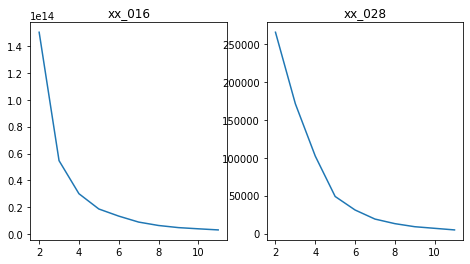

In [30]:
from sklearn.cluster import KMeans
plt.figure(figsize=(12,4))
k = 1
for var in ['xx_016','xx_028']:
    inertia = []

    for nc in range(2,12):
        kmeans = KMeans(n_clusters=nc)
        kmeans.fit(df[var].values.reshape(-1,1))
        inertia.append(kmeans.inertia_)  
    plt.subplot(1,3,k)
    plt.plot(range(2,12),inertia)
    plt.title(var)
    k+=1


In [31]:
from sklearn.preprocessing import MinMaxScaler
df_combo = df.copy()
for var in ['xx_016','xx_028']:
    if var == 'xx_028':
        n_clust = 5
    else:
        n_clust = 4
    # Generate new cluster
    kmeans = KMeans(n_clusters=n_clust)
    df_temp = pd.DataFrame(df_combo[var].copy())
    df_temp[var+'_cluster'] = kmeans.fit_predict(df_combo[var].values.reshape(-1,1))
    # analyze cluster
    tab = df_temp.groupby(var+'_cluster').agg({var:['mean','min','max','std']})
    #print(tab)
    # sort cluster
    new_clust = np.argsort(tab[var].loc[:,'min'])
    temp = np.zeros(len(df_temp[var+'_cluster']),dtype=int)
    for i in range(len(new_clust)):
        #print(i,new_clust[i])
        temp[df_temp[var+'_cluster']==new_clust[i]]=i
    df_temp.loc[:,var+'_cluster'] = temp
    print(df_temp.groupby(var+'_cluster').agg({var:['mean','min','max','std']}))
    # Create dummy features
    df_temp2 = pd.get_dummies(df_temp[var+'_cluster'],prefix=var, prefix_sep='_')
    # Add to data set
    df_combo = pd.concat([df_combo,df_temp2],axis=1)
    # Rescale the data set
    mms = MinMaxScaler()
    mms.fit(df_combo[var].values.reshape(-1,1))
    df_combo[var] = mms.transform(df_combo[var].values.reshape(-1,1))

                       xx_016                              
                         mean     min     max           std
xx_016_cluster                                             
0                  954.811861       0  170000  11335.080341
1               346677.467105  179700  437600  61848.089901
2               538566.912610  447000  618200  46043.352644
3               704526.062992  621800  921528  59939.416659
                    xx_028                    
                      mean min  max        std
xx_028_cluster                                
0                 0.006152   0    1   0.078197
1                 2.551692   2    6   0.809375
2                10.495624   7   24   3.522496
3                38.232323  25   53   7.286874
4               102.230769  81  152  27.374890


In [32]:
df_combo.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
xx_006,38432.0,0.448350,2.283522,0.0,0.0,0.000000,0.000000,40.0
xx_005,38432.0,1.264051,2.185513,-2.0,0.0,0.000000,2.000000,6.0
xx_016,38432.0,0.143841,0.275517,0.0,0.0,0.000000,0.000000,1.0
xx_028,38432.0,0.011783,0.025496,0.0,0.0,0.013158,0.013158,1.0
error,38432.0,0.049074,0.216025,0.0,0.0,0.000000,0.000000,1.0
xx_016_0,38432.0,0.776566,0.416552,0.0,1.0,1.000000,1.000000,1.0
xx_016_1,38432.0,0.031640,0.175043,0.0,0.0,0.000000,0.000000,1.0
xx_016_2,38432.0,0.086048,0.280439,0.0,0.0,0.000000,0.000000,1.0
xx_016_3,38432.0,0.105745,0.307515,0.0,0.0,0.000000,0.000000,1.0
xx_028_0,38432.0,0.435627,0.495845,0.0,0.0,0.000000,1.000000,1.0


In [33]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38432 entries, 0 to 39062
Data columns (total 49 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id_013    38432 non-null  object 
 1   id_014    38432 non-null  object 
 2   xx_006    38432 non-null  float64
 3   cl_002    38432 non-null  object 
 4   cl_004    38432 non-null  object 
 5   flg_000   38432 non-null  object 
 6   flg_004   38432 non-null  object 
 7   ty_000    38432 non-null  object 
 8   cl_000    38432 non-null  object 
 9   xx_000    38432 non-null  object 
 10  id_001    38432 non-null  object 
 11  xx_001    38432 non-null  object 
 12  cl_001    38432 non-null  object 
 13  id_002    38432 non-null  object 
 14  id_003    38432 non-null  object 
 15  id_004    38432 non-null  object 
 16  id_005    38432 non-null  object 
 17  id_006    38432 non-null  object 
 18  id_007    38432 non-null  object 
 19  id_008    38432 non-null  object 
 20  xx_005    38432 non-null  in

### xx_005 is an ordinal variable

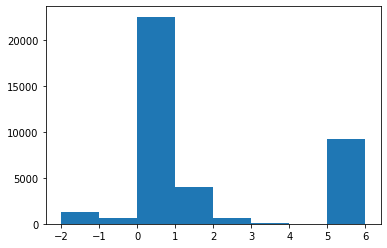

In [33]:
plt.hist(df['xx_005'],bins=range(-2,7))
plt.show()

In [34]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(df_combo['xx_005'].values.reshape(-1,1))
df_combo['xx_005'] = mms.transform(df_combo['xx_005'].values.reshape(-1,1))

## Create dummy features

In [35]:
df_dum = df_combo.copy()
for var in df_dum.columns:
    if (var == 'id_000')|(var == 'id_033')|(var == 'dt_001'):
        continue
    if (df_dum[var].dtype=='O'):
        if ('1' in df_dum[var].unique())|('0.0' in df_dum[var].unique())|(('0' in df_dum[var].unique())):
            print(var, ' has integers as strings')
            continue
        if isinstance(df[var].unique()[0],str):
            if sum([1 if var not in value else 0 for value in df[var].unique()]) > 0:
                df_temp = pd.get_dummies(df_combo[var],drop_first=True,prefix_sep='_',prefix=var)
            else:
                df_temp = pd.get_dummies(df_combo[var],drop_first=True)
        else:
            df_temp = pd.get_dummies(df_combo[var],drop_first=True)
        df_dum = pd.concat([df_dum.drop(var,axis=1),df_temp],axis=1)
        del df_temp
    else:
        print('Integer values: ',var,' ::: ',df_dum[var].nunique())


Integer values:  xx_006  :::  26
Integer values:  xx_005  :::  8
Integer values:  xx_016  :::  991
Integer values:  xx_028  :::  63
Integer values:  error  :::  2
Integer values:  xx_016_0  :::  2
Integer values:  xx_016_1  :::  2
Integer values:  xx_016_2  :::  2
Integer values:  xx_016_3  :::  2
Integer values:  xx_028_0  :::  2
Integer values:  xx_028_1  :::  2
Integer values:  xx_028_2  :::  2
Integer values:  xx_028_3  :::  2
Integer values:  xx_028_4  :::  2


## Add time and date features

In [36]:
x = 'dt_001'
df_dum[x] = pd.to_datetime(df_dum[x])
df_dum.loc[:,x] = df_dum[x].apply(lambda y: y.replace(microsecond=0))

In [37]:
df_time=pd.DataFrame(df_dum['dt_001'].copy(),columns=['dt_001'])
df_time['month']=[x.month for x in df_dum['dt_001']]
df_time['day']=[x.day for x in df_dum['dt_001']]
df_time['hour']=[x.hour for x in df_dum['dt_001']]
df_time['weekday']=[x.weekday() for x in df_dum['dt_001']]

df_dum['morning'] = [0 if x >= 12 else 1 for x in df_time['hour']]
df_dum['afternoon'] = [0 if (x < 12)|(x>18) else 1 for x in df_time['hour']]
df_dum['evening'] = [0 if (x <= 18) else 1 for x in df_time['hour']]

wdays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(7):
    df_dum[wdays[i]] = [1 if x == i else 0 for x in df_time['weekday']]
df_dum.drop('dt_001',axis=1,inplace=True)

We will now take out the sparsest category per feature to further reduce the data set.

In [39]:
np.sum(df_dum.loc[:,['morning','afternoon','evening']],axis=0)

morning      15260
afternoon    18924
evening       4248
dtype: int64

In [38]:
df_dum.drop(['evening','Sunday'],axis=1,inplace=True)

It appears that the clustering is not adding more value to the data set, nor the PCA decomposition. For now they will not be included to the data set.

## Split test and training data set

In [40]:
print('Errors make up only {:.2f}% of the data set.'.format(df_dum['error'].sum()/df_dum['error'].count()*100))

Errors make up only 4.91% of the data set.


Therefore, the test and training set are split such that each has 4.83 % errors.

In [41]:
import scipy as sp
from sklearn.model_selection import train_test_split
y = df_dum['error'].values
X = sp.sparse.csr_matrix(df_dum.drop('error',axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42,stratify=y)
print('Training data: ',len(y_train),' Testing data: ',len(y_test))

Training data:  30745  Testing data:  7687


In [43]:
print('In the train set errors make up {:.2f}% of the data.'.format(y_train.sum()/len(y_train)*100))
print('In the test set errors make up {:.2f}% of the data.'.format(y_test.sum()/len(y_test)*100))

In the train set errors make up 4.91% of the data.
In the test set errors make up 4.90% of the data.


## Save data sets

In [42]:
con = sqlite3.connect('../data/model_data_extra_base2.db')
pd.DataFrame(y_train,columns=['error']).to_sql(name='y_train', con=con, if_exists='replace')
pd.DataFrame(y_test,columns=['error']).to_sql(name='y_test', con=con, if_exists='replace')
con.close()

In [43]:
from scipy.sparse import csr_matrix, save_npz, load_npz

save_npz('../data/data_extra_base_Xtrain2.npz',X_train)
save_npz('../data/data_extra_base_Xtest2.npz',X_test)

In [44]:
np.save('../data/data_extra_base_columns2',df_dum.columns)